In [64]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")
    

def read_orders():
    orders = pd.read_csv("C:/Users/anis_/Desktop/Data/Jupyter/Instacart/orders.csv")
    return orders[['order_id','user_id']]

def read_products():
    products = pd.read_csv("C:/Users/anis_/Desktop/Data/Jupyter/Instacart/products.csv")
    products = products.dropna(subset = ['department_id'])
    #print(pd.unique(products['department_id']))
    return products[['product_id','department_id']]

def read_orders_products():
    orders_products = pd.read_csv("C:/Users/anis_/Desktop/Data/Jupyter/Instacart/order_products__prior.csv")
    #orders_train = pd.read_csv("C:/Users/anis_/Desktop/Data/Jupyter/Instacart/order_products__train.csv")
    #orders_products= pd.concat([orders_prior, orders_train], axis=0)
    return orders_products[['order_id','product_id']]

def user_table(nb_users):
    df_orders = read_orders()
    df_products = read_products()
    df_orders_products = read_orders_products()
    
    users = pd.merge(df_orders, df_orders_products, on='order_id')
    users = pd.merge(users, df_products, on='product_id')
    users = users[['order_id', 'user_id', 'department_id']]
    
    user_col = pd.unique(users['user_id']).tolist()
    user_col = user_col[:nb_users]
    rows = []
    
    for i in user_col:
        data = users[users['user_id'] == i]
        #data = data.sort_values(by = ['order_id'], ascending = True)
        order_col = pd.unique(data['order_id']).tolist()
        
        liste = []
        #liste_order = []
        for j in order_col:
            #liste_order.append(j)
            liste.append(data[data['order_id'] == j]['department_id'])
            
        rows.append([i,liste])
    df = pd.DataFrame(rows, columns = ['user_id', 'department_id'])
    df = df['department_id']
    
    return df 

In [65]:
def final_table():
    nb_users = 10000
    df = user_table(nb_users)
    maxlen = 12
    T = 5
    panier = 21
    
    X = np.array(df)
    X = np.zeros((nb_users, T, maxlen))
    for i in range(len(df)):
        xi = pad_sequences(sequences = df[i], maxlen = maxlen, dtype = 'int32', padding = 'pre', truncating = 'pre', value = 0)
        t = min(T, xi.shape[0])
        xi = xi[:t]
        a = T - t
        X[i][a:] = xi
        
    data = []
    label = []
    
    for user in X:
#         print("USER:", user)
#         print("\n")
        liste = [] 
        for order in user:
            #print("ici c order", order)
            p = np.zeros(panier + 1) 
            for department in order:
                #print("ici c departement", department)
                #print("\n")
                x = int(department) 
                if x == 0:
                    p[x] = 0
                else:
                    p[x] = 1

            liste.append(list(p))
#             print("ici on fait la liste", liste)
#             print("\n")
            
        X_encoded = liste[:][:-1][:]
#         print("ici c data", X_encoded)
#         print('\n')
        data.append(X_encoded)
#         print("ici c data", data)
#         print('\n')
    
        Y_encoded = liste[:][-1][:] 
#         print("ici c Y_encoded", Y_encoded)
#         print('\n')
        label.append(Y_encoded)
#         print("ici c label",  label)  
#         print('\n')
#         i = i+1
#         print(i)
            
        #data_encoded.append(liste) 
    
    
    data = np.array(data)
    label = np.array(label)
#     print("data: ", data)
#     print("\n")
#     print("label: " , label)

    return data,label
    

In [66]:
def apply_model():
    
    df = final_table()
    X = df[0]
    Y = df[1]
    
    maxlen = 22
    T = 4
    
    X_train , X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3)
    
    model_lstm = Sequential()
    model_lstm.add(LSTM(256, input_shape = (T, maxlen)))
    model_lstm.add(Dense(64, activation = 'sigmoid'))
    model_lstm.add(Dropout(0.25))
    model_lstm.add(Dense(maxlen, activation = 'softmax'))
   
    model_lstm.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
    
    history = model_lstm.fit(X_train, y_train, epochs = 100, validation_split = 0.1, batch_size = 256)
    
    plt.clf()
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'g', label='Training loss')
    plt.plot(epochs, val_loss, 'y', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    plt.clf()
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    plt.plot(epochs, acc, 'g', label='Training acc')
    plt.plot(epochs, val_acc, 'y', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    p_train = model_lstm.predict(X_train)
    p_test = model_lstm.predict(X_test)
    
    # Accuracy
    train_acc = accuracy_score(np.argmax(y_train,axis=1), np.argmax(p_train,axis=1))
    test_acc = accuracy_score(np.argmax(y_test,axis=1 ), np.argmax(p_test,axis=1))
    print(train_acc)
    print(test_acc)
    

Train on 6300 samples, validate on 700 samples
Epoch 1/100
6300/6300 [==============================] - 3s 446us/step - loss: 0.6045 - accuracy: 0.8223 - val_loss: 0.5430 - val_accuracy: 0.8127
Epoch 2/100
6300/6300 [==============================] - 2s 375us/step - loss: 0.5101 - accuracy: 0.8223 - val_loss: 0.5273 - val_accuracy: 0.8127
Epoch 3/100
6300/6300 [==============================] - 2s 370us/step - loss: 0.5001 - accuracy: 0.8223 - val_loss: 0.5204 - val_accuracy: 0.8127
Epoch 4/100
6300/6300 [==============================] - 2s 372us/step - loss: 0.4928 - accuracy: 0.8223 - val_loss: 0.5139 - val_accuracy: 0.8127
Epoch 5/100
6300/6300 [==============================] - 2s 372us/step - loss: 0.4868 - accuracy: 0.8223 - val_loss: 0.5092 - val_accuracy: 0.8127
Epoch 6/100
6300/6300 [==============================] - 2s 372us/step - loss: 0.4820 - accuracy: 0.8223 - val_loss: 0.5067 - val_accuracy: 0.8127
Epoch 7/100
6300/6300 [==============================] - 2s 392us/step 

6300/6300 [==============================] - 3s 418us/step - loss: 0.4403 - accuracy: 0.8256 - val_loss: 0.4822 - val_accuracy: 0.8149
Epoch 57/100
6300/6300 [==============================] - 3s 416us/step - loss: 0.4403 - accuracy: 0.8254 - val_loss: 0.4830 - val_accuracy: 0.8151
Epoch 58/100
6300/6300 [==============================] - 3s 417us/step - loss: 0.4397 - accuracy: 0.8257 - val_loss: 0.4822 - val_accuracy: 0.8152
Epoch 59/100
6300/6300 [==============================] - 3s 422us/step - loss: 0.4390 - accuracy: 0.8255 - val_loss: 0.4834 - val_accuracy: 0.8150
Epoch 60/100
6300/6300 [==============================] - 3s 429us/step - loss: 0.4386 - accuracy: 0.8256 - val_loss: 0.4827 - val_accuracy: 0.8148
Epoch 61/100
6300/6300 [==============================] - 3s 429us/step - loss: 0.4385 - accuracy: 0.8256 - val_loss: 0.4825 - val_accuracy: 0.8148
Epoch 62/100
6300/6300 [==============================] - 3s 427us/step - loss: 0.4380 - accuracy: 0.8256 - val_loss: 0.4823 

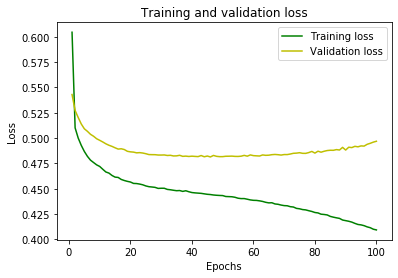

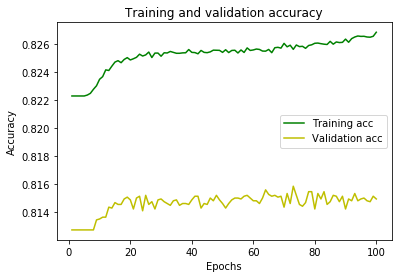

0.3752857142857143
0.32133333333333336


In [67]:
apply_model()